In [10]:
import numpy as np
from matplotlib import pyplot as plt
import sys

# only do longitudual friction
# print("x = {0}".format(x))

mad = np.array([2,3,4])

def grad_h(func, nodes): # Gradiant h
    """ Modified trapezoidal integration"""
    # Pads a 0 at the end of an array
    temp = pad_along_axis(func, nodes,axis = 1) # Using roll calculate the diff (ghost node of 0)

    return (temp - np.roll(temp, 1))

def pad_along_axis(array: np.ndarray, target_length: int, axis: int = 0):

    pad_size = target_length - array.shape[axis]

    if pad_size <= 0:
        return array

    npad = [(0, 0)] * array.ndim
    npad[axis] = (0, pad_size)

    return np.pad(array, pad_width=npad, mode='constant', constant_values=0)

class crossrod:
    def __init__(self, T, dt, total_length, elements, density, radius, total_external_force,
                 G = 1E4, E = 1E6, dim = 3, **kwargs):
        # Plotting
        self.final_pos = []

        # Element Info
        self.e = elements
        self.n = self.e + 1 # nodes
        self.n_i = self.e - 1 # internal nodes

        # Initializing node mass
        self.area = np.pi * (radius**2) # Update?
        total_volume = self.area * total_length
        total_mass = density * total_volume
        self.m = np.zeros((1,self.n))
        element_mass = total_mass / self.e
        self.m[0][0] = element_mass/2
        self.m[0][1:self.n-1] = element_mass
        self.m[0][self.n-1] = element_mass/2

        # Initializing node radii
        self.r = np.full((1,self.n),radius) # Update?

        # Initializing node position
        self.pos = np.zeros((dim,self.n))
        for col in range(self.n):
            self.pos[2,col] = (total_length/self.e) * col

        # Length Info
        # UPDATE THIS AT EVERY TIME STEP
        self.l = self.pos[:,1:] - self.pos[:,:-1] # length vector
        self.l_mag = np.linalg.norm(self.l, axis = 0) # magnitude of length
        # DO NOT UPDATE THIS AT EVERY TIME STEP
        self.l_ref = self.pos[:,1:] - self.pos[:,:-1] # reference length (unstrecthed length of the rod)
        self.l_ref_mag = np.linalg.norm(self.l_ref, axis = 0) # magnitude of reference length as a scalar

        # Parameters determined by Length Info
        self.dil_fac = self.l_mag / self.l_ref_mag # dilatation factor
        self.tangents = self.l / self.l_mag # tangent vectors

        # Directors
        self.directors = np.zeros((3, 3, self.e))
        for idx in range(self.e):
            self.directors[:, :, idx] = np.eye(3) # maps from lab to material frame

        self.forces = np.zeros((dim,self.n)) # forces INITIALIZE
        self.forces[2,self.e] = total_external_force

        self.vel = np.zeros((dim,self.n)) # velocities

        # Shear/stretch diagonal matrix INITIALIZE INPUT FROM MATERIAL PROPERTIES
        self.S_hat = np.zeros((3,3,self.e))
        alpha_c = 4./3. # shape factor
        self.S_hat[0,0,:] = alpha_c * G * self.area
        self.S_hat[1,1,:] = alpha_c * G * self.area
        self.S_hat[2,2,:] = E * self.area

        # Moment of inertia diagonal matrix 
        self.I = np.zeros((3,3,self.e))
        self.I[0,0,:] = self.area**2 / 4 * np.pi
        self.I[1,1,:] = self.area**2 / 4 * np.pi
        self.I[2,2,:] = self.area**2 / 4 * np.pi * 2
        
        # Bend diagonal matrix INITIALIZE INPUT FROM MATERIAL PROPERTIES
        self.B = np.zeros((3,3,self.n_i))
        self.B[0,0,:] = E * self.I[0,0,:]
        self.B[1,1,:] = E * self.I[1,1,:]
        self.B[2,2,:] = G * self.I[2,2,:]
        
        # J diagonal matrix. 
        # **** if broken code, there might be some difference between dJ^ and J^
        # here i assume J is pI from dJ = pIds
        self.J = np.zeros((3,3,self.e))
        self.J[0,0,:] = density * self.I[0,0,:]
        self.J[1,1,:] = density * self.I[1,1,:]
        self.J[2,2,:] = density * self.I[2,2,:]
        
        
        # shear/stress strain
        self.s = self.dil_fac * self.tangents - self.directors[2,:,:]

        
        
        # Governing Equations
        # pos += vel * dt # Equation 1
        # dv_dt = (grad_h(S_hat @ s / dil_fac) + f) / m # Equation 3

        for x in np.arange(0,T+dt,dt):
            self.pos, self.vel = self.position_verlet(dt, self.pos, self.vel)
            self.update(self.pos)
            self.final_pos.append(self.pos[2,-1])


    def position_verlet(self, dt, x, v):
        """Does one iteration/timestep using the Position verlet scheme
        Parameters
        ----------
        dt : float
            Simulation timestep in seconds
        x : float/array-like
            Quantity of interest / position of COM
        v : float/array-like
            Quantity of interest / velocity of COM
        force_rule : ufunc
            A function, f, that takes one argument and
            returns the instantaneous forcing
        Returns
        -------
        x_n : float/array-like
            The quantity of interest at the Next time step
        v_n : float/array-like
            The quantity of interest at the Next time step
        """
        # temp_x = np.zeros((3,self.n))
        # x_n = np.zeros((3,self.n))
        temp_x = x + 0.5*dt*v
        v_n = v + dt * self.force_rule(temp_x)
        x_n = temp_x + 0.5 * dt * v_n
        return x_n, v_n

    def bend_rule(self, temp_pos):
        
        self.update(temp_pos)
        
        matmul = np.zeros((3,self.e))
        # for i in range(self.e):
        #     matmul[:, i] = self.S_hat[:, :, i] @ self.s[:, i]
        matmul = np.einsum('ijk,jk->ik',self.B,self.kappa)

        self.internal_bend = grad_h(self.B * self.kappa, self.n)

        dv_dt = (self.internal_force + self.forces)  / self.m
    
        return dw_dt
    
    def force_rule(self, temp_pos):
        # First update
        self.update(temp_pos)

        matmul = np.zeros((3,self.e))
        # for i in range(self.e):
        #    matmul[:, i] = self.S_hat[:, :, i] @ self.s[:, i]
        matmul = np.einsum('ijk,jk->ik',self.S_hat,self.s)

        self.internal_force = grad_h(matmul / self.dil_fac, self.n)

        dv_dt = (self.internal_force + self.forces)  / self.m
        return dv_dt

    def update(self, temp_pos):
        # Constrain 1st node position
        temp_pos[:,0] = 0

        # Update Length
        self.l = temp_pos[:,1:] - temp_pos[:,:-1]
        self.l_mag = np.linalg.norm(self.l, axis = 0)

        # Update dilatation factor
        self.dil_fac = self.l_mag / self.l_ref_mag

        # Update tangents
        self.tangents = self.l / self.l_mag

        # Update shear/stress strain
        self.s = self.dil_fac * self.tangents - self.directors[2,:,:]
        pass


In [11]:
F = 15
E = 1E6
R = .1
A = np.pi * R**2
L = 1
T = 100
dt = 3E-4

position = [[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.02859308 0.05718901 0.08578719 0.11438559 0.14298378
  0.17158106 0.20017935 0.22878059 0.25738148 0.28598476 0.31458378
  0.34318737 0.37179127 0.40039837 0.42900352 0.45760629 0.48620889
  0.51481009 0.5434075  0.57200213 0.60059219 0

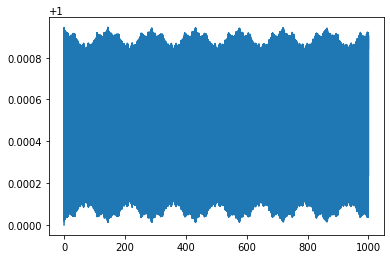

In [12]:
test = crossrod(T = T, dt = dt, total_length = L, elements = 35, density = 5E3, radius = R, total_external_force = F)
print("position = {0}".format(test.pos))
real_strain = (F*L)/(E*A-F)
print(real_strain)
print(np.average(test.final_pos))
plt.plot(np.arange(0,T+dt,dt),test.final_pos)
plt.show()